In [48]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [49]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [50]:
from scipy.signal import lfilter, firls, decimate

In [51]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def TuningKappaNew(self, kappas):
        assert self.finalRes is not None, "Run main function first!"
        
        MaxM = self.paras.MaxM
        U0 = self.finalRes.U0 
        rAct, n = self.midRes.nXmat.shape
        r = self.paras.r
        Us = []
        for kappac in kappas:
            Us.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))
        Us = np.array(Us)
        numchgs = Us.argmin(axis=1)
        self.numchgs = numchgs
        argIdx = np.argmin(np.diff(numchgs)/np.diff(kappas))
        
        self.Us = Us
        mUs = Us.min(axis=1)
        argmU = np.argmin(mUs)
        
        chgsKappas = []
        for numchg in numchgs:
            chgsKappas.append(self.finalRes.chgMat[numchg-1, :numchg])
        
        res = edict()
        res.kp1 = kappas[argIdx+1]
        res.numChgs1 = numchgs[argIdx+1]
        res.cpts1 = self.finalRes.chgMat[res.numChgs1-1, :res.numChgs1] 
        res.kp2 = kappas[argmU]
        res.numChgs2 = numchgs[argmU]
        res.cpts2 = self.finalRes.chgMat[res.numChgs2-1, :res.numChgs2] 
        res.chgsKappas = chgsKappas
        
        return res
   

In [52]:
def dHdist(set1, set2, n=155):
    set1 = np.array(set1)
    set2 = np.array(set2)
    if len(set2) == 0:
        return 0
    if len(set1) == 0:
        return n
    else:
        absDiff = np.abs(set1.reshape(-1, 1) - set2.reshape(1, -1))
        return absDiff.min(axis=0).max()

In [53]:
def Hdist(set1, set2, n=155):
    d1 = dHdist(set1, set2, n=n)
    d2 = dHdist(set2, set1, n=n)
    return np.max((d1, d2))

In [55]:
dHdist([1, 2, 3, 4, 5], [1,2 ,3, 4])

0

In [7]:
resDir = Path("../results")
dataDir = Path("../data")

In [8]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

# 1. Obtain data after HPF

In [9]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

In [10]:
num = 243
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

### sample plots 

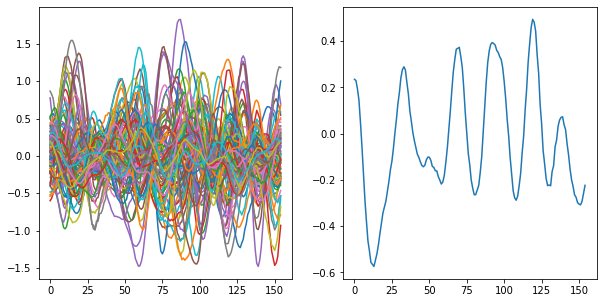

In [11]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(fMRIsHPF[4][i, :])
    
plt.subplot(122)
plt.plot(fMRIsHPF[4][10, :])

# 2. Obtain seamed data

1. divide whole data into `k` segments
2. the grand truth are different for different data

In [12]:
def GenRanCpts(ncpt, Lmin, n=155):
    Mdiff = 0
    
    while (Mdiff <=Lmin):
        cpts = np.random.choice(n, size=ncpt, replace=False)
        cpts = np.sort(cpts)
        Mdiff = np.min(np.abs(np.diff(cpts)))
        Mdiff = np.min((cpts[0], Mdiff, n-cpts[-1]))
    return cpts

In [13]:
#GTs = np.array([
#   [30, 85, 130],
#   [20, 55, 80],
#   [80, 105, 135],
#   [35, 65, 100],
#   [50, 105, 125]
#] * 5)

numchgs = [2, 4, 8, 5, 7, 6, 5, 8, 9, 6]
GTs = [list(GenRanCpts(i, Lmin=10)) for i in numchgs]

GTsAll = []
for GT in GTs:
    numD = len(GT) + 1
    GTsAll = GTsAll + [GT] * numD

In [14]:
d, n = fMRIsHPF[0].shape

In [15]:
seamedDatas = []
idxC = 0
for GT in GTs:
    GT = np.array(GT)
    numD = len(GT) + 1
    GT = GT - 1
    GT2 = np.concatenate([GT, [n]]) + 1 
    GT1 = np.concatenate([[0], GT+1])
    cDs = [np.zeros((d, n)) for ii in range(numD)]
    for k in range(numD):
        for l in range(numD):
            cDs[l][:, GT1[k]:GT2[k]] = fMRIsHPF[idxC+(k+l)%numD][:, GT1[k]:GT2[k]]
    idxC += numD
    seamedDatas = seamedDatas + cDs

### Verify the seamed data

In [16]:
#seamedDatas[11][:, 120:] - fMRIsHPF[10][:, 120:]

### sample plots 

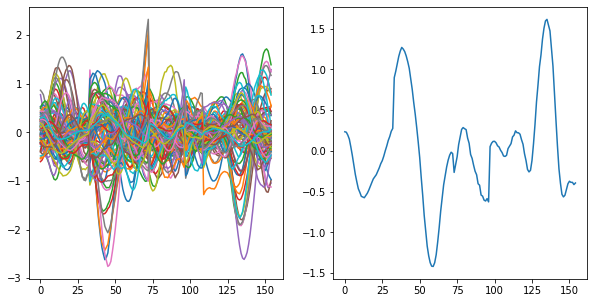

In [17]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
for i in range(90):
    plt.plot(seamedDatas[4][i, :])
    
plt.subplot(122)
plt.plot(seamedDatas[4][10, :])

# 3. Detection for kappa

In [18]:
kappa = 1.53
r = 10
Lmin = 10

results = []
kappas = np.arange(0.68, 4, 0.01)
thdist = 0
for i in tqdm(range(len(seamedDatas))):
    Ymat = seamedDatas[i]
    simuDet = TVDNDetect1(Ymat=Ymat,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=1, freq=0.5, lamb=1e-3, showProgress=False, 
                          decimateRate=None, is_detrend=False)
    simuDet()
    GT = GTsAll[i]
    ecpts = simuDet.finalRes.chgMat[len(GT)-1, :len(GT)]
    chdist = Hdist(ecpts, GT)
    thdist += chdist
    
    print(i+1, np.round(thdist/(i+1), 3), Hdist(ecpts, GT), ecpts, GT)
    res = simuDet.TuningKappaNew(kappas)
    results.append(res.chgsKappas)

1 61.0 61.0 [ 68. 109.] [13, 48]
2 60.0 59.0 [ 42. 107.] [13, 48]
3 58.667 56.0 [ 54. 104.] [13, 48]
4 47.0 12.0 [ 32.  61.  87. 112.] [33, 73, 97, 109]
5 38.8 6.0 [ 33.  67.  95. 115.] [33, 73, 97, 109]
6 34.167 11.0 [ 35.  65.  92. 120.] [33, 73, 97, 109]
7 31.571 16.0 [ 36.  57.  81. 113.] [33, 73, 97, 109]
8 28.625 8.0 [ 31.  68.  93. 117.] [33, 73, 97, 109]
9 26.556 10.0 [ 13.  36.  56.  66.  82.  93. 110. 137.] [16, 29, 46, 61, 86, 108, 130, 142]
10 25.4 15.0 [ 11.  21.  34.  52.  66.  84. 106. 127.] [16, 29, 46, 61, 86, 108, 130, 142]
11 24.455 15.0 [ 13.  29.  40.  51.  65.  83. 106. 127.] [16, 29, 46, 61, 86, 108, 130, 142]
12 23.25 10.0 [ 10.  35.  49.  61.  84.  98. 116. 137.] [16, 29, 46, 61, 86, 108, 130, 142]
13 22.308 11.0 [ 27.  47.  63.  75.  89. 102. 113. 137.] [16, 29, 46, 61, 86, 108, 130, 142]
14 21.5 11.0 [ 23.  41.  59.  72.  85. 106. 121. 145.] [16, 29, 46, 61, 86, 108, 130, 142]
15 20.8 11.0 [ 10.  30.  51.  62.  75.  87. 111. 140.] [16, 29, 46, 61, 86, 108, 13

In [61]:
hdists = []
for k, ress in enumerate(results):
    GT = GTsAll[k]
    hdist = [Hdist(res, GT)for res in ress]
    hdists.append(hdist) 

In [62]:
hdists = np.array(hdists)

In [63]:
mhdist = hdists.mean(axis=0)

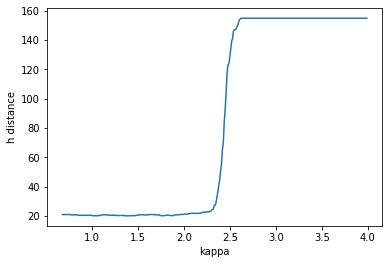

In [64]:
plt.xlabel("kappa")
plt.ylabel("h distance")
plt.plot(kappas, mhdist)

In [65]:
optKappa = kappas[np.argmin(mhdist)];optKappa

1.3800000000000008

# 4. Detection on optimal kappa

## Data 9

In [24]:
fMRI9 = fMRIs[0, 9]["fMRI"][:90, :]
fMRI9 = detrend(fMRI9)
hpffMRI = lfilter(hbp, 1, fMRI9)
hpffMRI = hpffMRI[:, 25:]

In [25]:
r = 10 
Lmin = 10

In [26]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


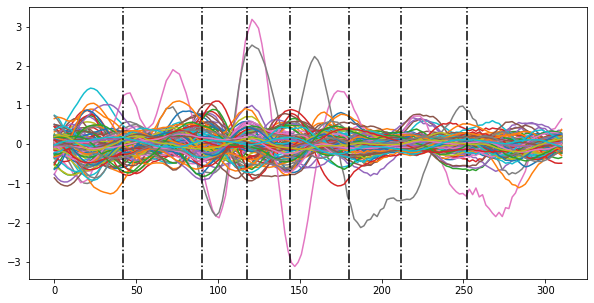

In [27]:
fMRIDet.PlotEcpts()

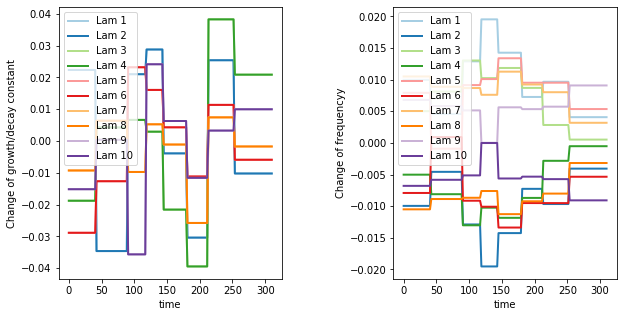

In [28]:
fMRIDet.PlotEigenCurve()

In [29]:
print(fMRIDet)

+-------------+-------------------------------+--------------------+------+
| Num of CPTs |         Estiamted CPTs        |        MSE         | Rank |
+-------------+-------------------------------+--------------------+------+
|      7      | [ 21  45  59  72  90 106 126] | 2.9315441833900344 |  10  |
+-------------+-------------------------------+--------------------+------+


## Data 100

In [30]:
fMRI100 = fMRIs[0, 100]["fMRI"][:90, :]
fMRI100 = detrend(fMRI100)
hpffMRI = lfilter(hbp, 1, fMRI100)
hpffMRI = hpffMRI[:, 25:]

In [31]:
r = 10
Lmin = 10

In [32]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


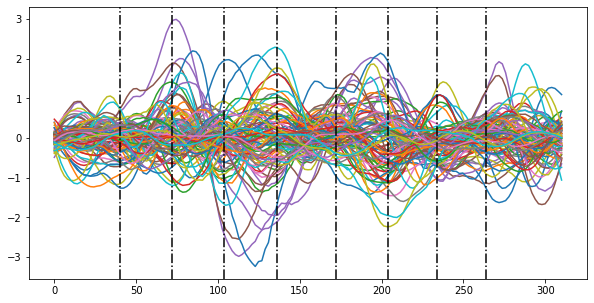

In [33]:
fMRIDet.PlotEcpts()

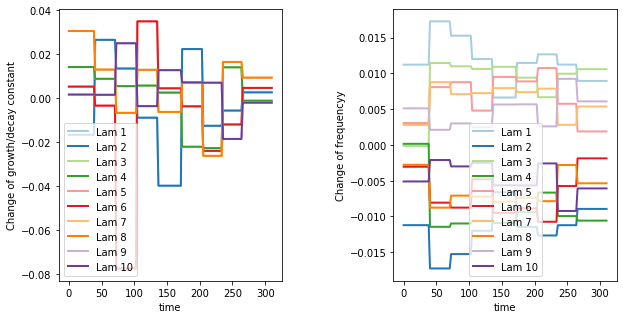

In [34]:
fMRIDet.PlotEigenCurve()

In [35]:
print(fMRIDet)

+-------------+-----------------------------------+--------------------+------+
| Num of CPTs |           Estiamted CPTs          |        MSE         | Rank |
+-------------+-----------------------------------+--------------------+------+
|      8      | [ 20  36  52  68  86 102 117 132] | 1.5311617262690593 |  10  |
+-------------+-----------------------------------+--------------------+------+


## Data 150

In [36]:
fMRI150 = fMRIs[0, 150]["fMRI"][:90, :]
fMRI150 = detrend(fMRI150)
hpffMRI = lfilter(hbp, 1, fMRI150)
hpffMRI = hpffMRI[:, 25:]

In [37]:
r = 10
Lmin = 10

In [38]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


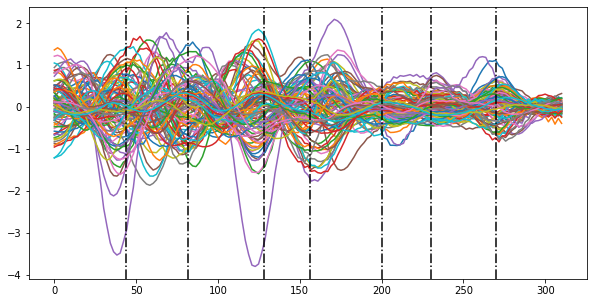

In [39]:
fMRIDet.PlotEcpts()

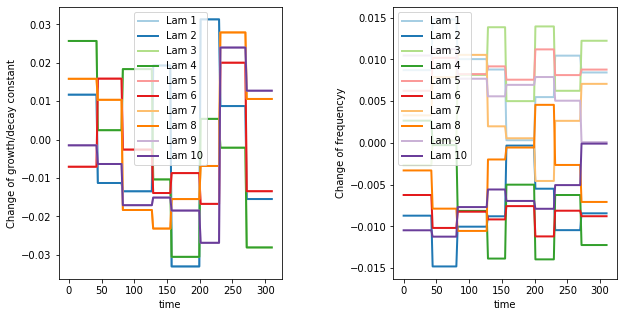

In [40]:
fMRIDet.PlotEigenCurve()

In [41]:
print(fMRIDet)

+-------------+-------------------------------+-------------------+------+
| Num of CPTs |         Estiamted CPTs        |        MSE        | Rank |
+-------------+-------------------------------+-------------------+------+
|      7      | [ 22  41  64  78 100 115 135] | 2.209243202619834 |  10  |
+-------------+-------------------------------+-------------------+------+


## Data 200

In [42]:
fMRI200 = fMRIs[0, 200]["fMRI"][:90, :]
fMRI200 = detrend(fMRI200)
hpffMRI = lfilter(hbp, 1, fMRI200)
hpffMRI = hpffMRI[:, 25:]

In [43]:
r = 10
Lmin = 10

In [44]:
fMRIDet = TVDNDetect1(Ymat=hpffMRI,  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
fMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


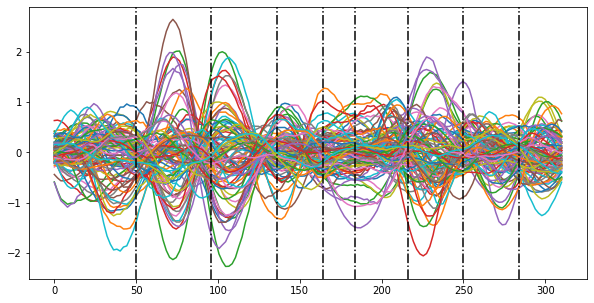

In [45]:
fMRIDet.PlotEcpts()

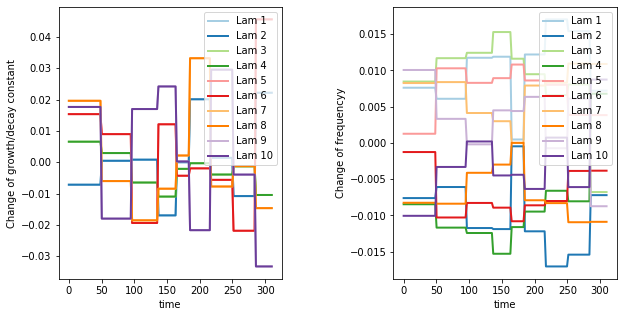

In [46]:
fMRIDet.PlotEigenCurve()

In [47]:
print(fMRIDet)

+-------------+-----------------------------------+--------------------+------+
| Num of CPTs |           Estiamted CPTs          |        MSE         | Rank |
+-------------+-----------------------------------+--------------------+------+
|      8      | [ 25  48  68  82  92 108 125 142] | 1.3109184875805602 |  10  |
+-------------+-----------------------------------+--------------------+------+


## Results on seamed data

### Data 10

In [99]:
r = 10
Lmin = 10
idx = 10

In [100]:
seamedfMRIDet = TVDNDetect1(Ymat=seamedDatas[idx],  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
seamedfMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


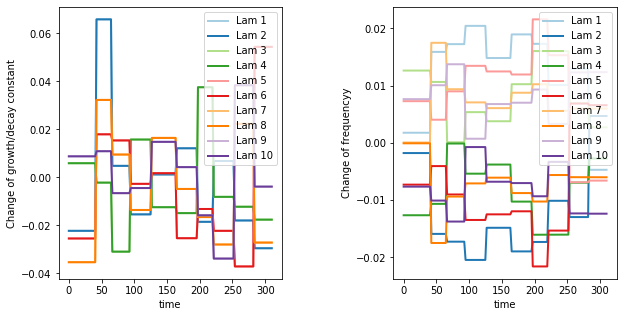

In [101]:
seamedfMRIDet.PlotEigenCurve()

In [102]:
print(seamedfMRIDet)

+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      9      | [ 21  33  47  63  82  98 110 126 141] | 1.6432730069873736 |  10  |
+-------------+---------------------------------------+--------------------+------+


#### truth

In [103]:
GTsAll[idx]

[16, 29, 46, 61, 86, 108, 130, 142]

#### detected vs truth

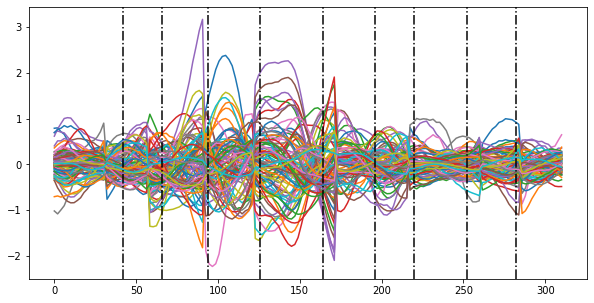

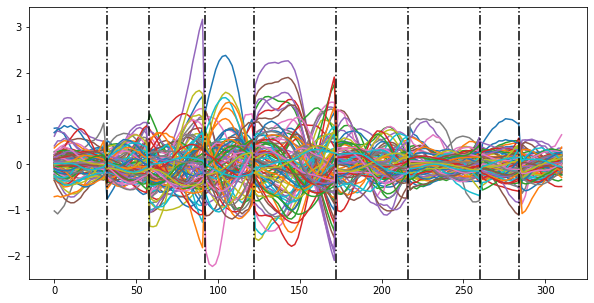

In [104]:
seamedfMRIDet.PlotEcpts()
seamedfMRIDet.ecpts = GTsAll[idx]
seamedfMRIDet.PlotEcpts()

### Data 20

In [105]:
r = 10
Lmin = 10
idx = 20

In [106]:
seamedfMRIDet = TVDNDetect1(Ymat=seamedDatas[idx],  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
seamedfMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


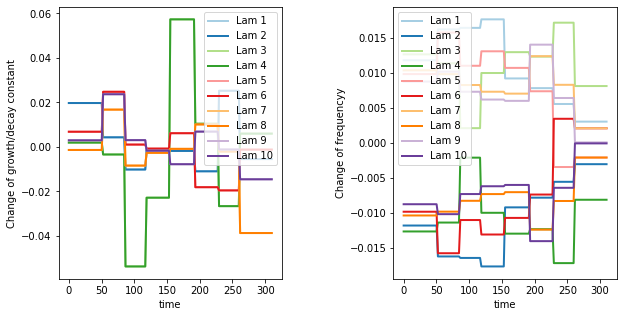

In [107]:
seamedfMRIDet.PlotEigenCurve()

In [108]:
print(seamedfMRIDet)

+-------------+-------------------------------+-------------------+------+
| Num of CPTs |         Estiamted CPTs        |        MSE        | Rank |
+-------------+-------------------------------+-------------------+------+
|      7      | [ 26  43  59  77  96 114 130] | 1.388489159030397 |  10  |
+-------------+-------------------------------+-------------------+------+


#### truth

In [109]:
GTsAll[idx]

[76, 93, 106, 126, 143]

#### detected vs truth

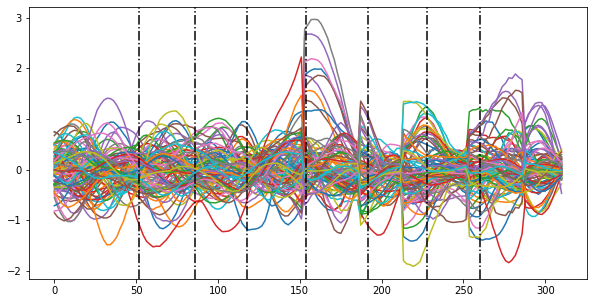

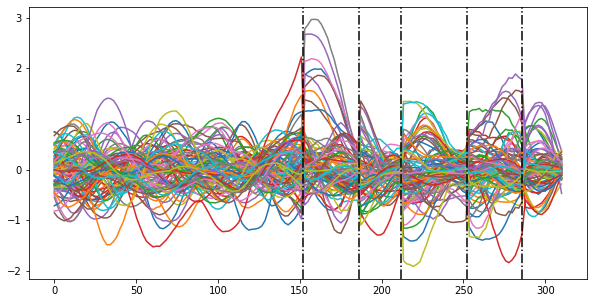

In [110]:
seamedfMRIDet.PlotEcpts()
seamedfMRIDet.ecpts = GTsAll[idx]
seamedfMRIDet.PlotEcpts()

### Data 50

In [111]:
r = 10
Lmin = 10
idx = 50

In [112]:
seamedfMRIDet = TVDNDetect1(Ymat=seamedDatas[idx],  saveDir=None, dataType="fMRI", Lmin=Lmin, downRate=4, fct=1, T=2, MaxM=10, 
                        fName="fMRI_HPF", r=r, kappa=optKappa, freq=0.5, lamb=1e-4, showProgress=True, 
                          decimateRate=None, is_detrend=False)
seamedfMRIDet()

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.3800000000000008,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 10}


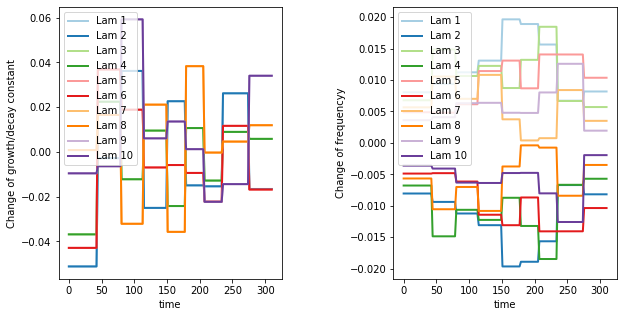

In [113]:
seamedfMRIDet.PlotEigenCurve()

In [114]:
print(seamedfMRIDet)

+-------------+-----------------------------------+--------------------+------+
| Num of CPTs |           Estiamted CPTs          |        MSE         | Rank |
+-------------+-----------------------------------+--------------------+------+
|      8      | [ 22  40  57  75  89 103 117 137] | 1.4777674771830285 |  10  |
+-------------+-----------------------------------+--------------------+------+


#### truth

In [115]:
GTsAll[idx]

[26, 43, 60, 77, 93, 112, 127, 141]

#### detected vs truth

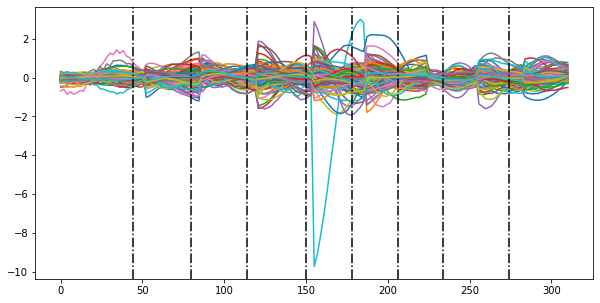

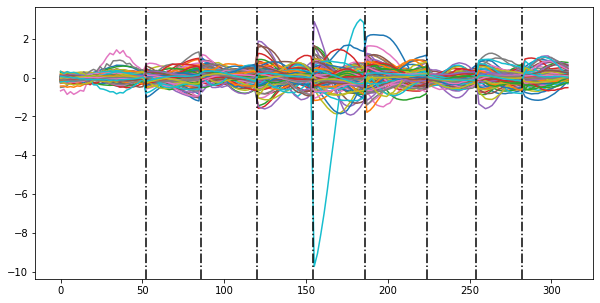

In [116]:
seamedfMRIDet.PlotEcpts()
seamedfMRIDet.ecpts = GTsAll[idx]
seamedfMRIDet.PlotEcpts()